### Import

In [1]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import stackstac
import xarray as xr
import datetime
import geopandas as gpd

import tensorflow as tf
import cv2
# import glob
# import os

import tensorflow as tf
from keras import layers, models

In [2]:

import geemap
import ee
ee.Authenticate()
ee.Initialize(project='static-potion-450322-u2') # this is the project for Ag Genius for porter.olson11@gmail.com

# ee.Initialize()

### Getting my Top 200 Geojson and Fixing it

In [1]:
counties=pl.read_csv(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\top_counties.csv')
counties=counties.select(['Year','State','County','State ANSI','County ANSI','Value'])
counties = counties.with_columns(
    pl.col("Value")
    .str.replace_all(",", "")      
    .cast(pl.Int64)                
)








NameError: name 'pl' is not defined

In [ ]:
planted=counties
natl=pl.read_csv(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\winter_wheat_natl.csv')
natl=natl.select(['Year','Value','State ANSI','County ANSI'])
natl=natl.rename({'Value':'yield'})
planted=planted.rename({'Value':'planted'})

In [ ]:
counties=planted.join(natl,on=['Year','State ANSI','County ANSI'])


In [ ]:
counties=counties.filter(pl.col('yield').is_not_null())
counties

Year,State,County,State ANSI,County ANSI,planted,yield
i64,str,str,i64,i64,i64,f64
2024,"""ILLINOIS""","""MACON""",17,115,3200,93.5
2024,"""ILLINOIS""","""MASON""",17,125,3500,91.2
2024,"""ILLINOIS""","""MENARD""",17,129,1900,91.9
2024,"""ILLINOIS""","""PEORIA""",17,143,1600,96.6
2024,"""ILLINOIS""","""WOODFORD""",17,203,5800,82.6
…,…,…,…,…,…,…
1994,"""WYOMING""","""CONVERSE""",56,9,1500,30.0
1994,"""WYOMING""","""GOSHEN""",56,15,45000,25.9
1994,"""WYOMING""","""LARAMIE""",56,21,95000,22.4


In [ ]:
counties = counties.with_columns([
    pl.col("State ANSI").cast(str).str.zfill(2),
    pl.col("County ANSI").cast(str).str.zfill(3)
])
counties = counties.with_columns([
    (pl.col("State ANSI") + pl.col("County ANSI")).alias("fips")

])


Year,State,County,State ANSI,County ANSI,planted,yield,fips
i64,str,str,str,str,i64,f64,str
2024,"""ILLINOIS""","""MACON""","""17""","""115""",3200,93.5,"""17115"""
2024,"""ILLINOIS""","""MASON""","""17""","""125""",3500,91.2,"""17125"""
2024,"""ILLINOIS""","""MENARD""","""17""","""129""",1900,91.9,"""17129"""
2024,"""ILLINOIS""","""PEORIA""","""17""","""143""",1600,96.6,"""17143"""
2024,"""ILLINOIS""","""WOODFORD""","""17""","""203""",5800,82.6,"""17203"""
…,…,…,…,…,…,…,…
1994,"""WYOMING""","""CONVERSE""","""56""","""009""",1500,30.0,"""56009"""
1994,"""WYOMING""","""GOSHEN""","""56""","""015""",45000,25.9,"""56015"""
1994,"""WYOMING""","""LARAMIE""","""56""","""021""",95000,22.4,"""56021"""


In [ ]:
counties=counties.filter(
    (pl.col('Year')<2024) & (pl.col('Year')>2012)
)
counties

Year,State,County,State ANSI,County ANSI,planted,yield,fips
i64,str,str,str,str,i64,f64,str
2023,"""ARKANSAS""","""ARKANSAS""","""05""","""001""",5800,59.6,"""05001"""
2023,"""ARKANSAS""","""CRITTENDEN""","""05""","""035""",18300,59.9,"""05035"""
2023,"""ARKANSAS""","""MONROE""","""05""","""095""",6800,60.1,"""05095"""
2023,"""ARKANSAS""","""PHILLIPS""","""05""","""107""",26900,63.2,"""05107"""
2023,"""ARKANSAS""","""PRAIRIE""","""05""","""117""",1400,63.1,"""05117"""
…,…,…,…,…,…,…,…
2013,"""WISCONSIN""","""SAUK""","""55""","""111""",6400,61.2,"""55111"""
2013,"""WISCONSIN""","""EAU CLAIRE""","""55""","""035""",500,40.4,"""55035"""
2013,"""WISCONSIN""","""MONROE""","""55""","""081""",800,45.5,"""55081"""


In [ ]:
import polars as pl

# Filter to years 2019–2023
recent_years = list(range(2019, 2024))
df_recent = counties.filter(pl.col("Year").is_in(recent_years))

# Step 1: Get top 400 FIPS in 2023 by planted acreage
top_2023 = (
    df_recent.filter(pl.col("Year") == 2023)
    .sort("planted", descending=True)
    .select(["fips"])
    .unique()
    .head(800)
)

# Step 2: Join to get only those FIPS
filtered = df_recent.join(top_2023, on="fips")

# Step 3: Count how many years each FIPS appears
year_counts = (
    filtered.group_by("fips")
    .agg(pl.col("Year").n_unique().alias("year_count"))
)

# Step 4: Filter to FIPS that appear in **all 5 years**
consistent_fips = year_counts.filter(pl.col("year_count") == 5)["fips"]

# Step 5: Final filtered dataset
final_df = filtered.filter(pl.col("fips").is_in(consistent_fips))

# Optional: Save or inspect
final_df.write_csv("top_2023_5year_consistent.csv")


C:\Users\porter77.BYU\AppData\Local\Temp\ipykernel_18576\3977946660.py:29: DeprecationWarning: `is_in` with a collection of the same datatype is ambiguous and deprecated.
Please use `implode` to return to previous behavior.

See https://github.com/pola-rs/polars/issues/22149 for more information.
  final_df = filtered.filter(pl.col("fips").is_in(consistent_fips))


In [ ]:
pl.Config(set_tbl_rows=10)

michigan_counties_df=final_df.filter(
    ((pl.col('State')=='MICHIGAN') & (pl.col('Year')==2023))
    
).sort(['planted','yield'],descending=True)

In [ ]:
pl.Config(set_tbl_rows=10)
df=pl.read_csv(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\top_2023_5year_consistent.csv')
df=df.filter(pl.col('Year')==2023)
df=df.sort('planted',descending=True)
df=df.head(200)
df


Year,State,County,State ANSI,County ANSI,planted,yield,fips
i64,str,str,i64,i64,i64,f64,i64
2023,"""MONTANA""","""CHOUTEAU""",30,15,391000,57.4,30015
2023,"""WASHINGTON""","""WHITMAN""",53,75,366000,70.5,53075
2023,"""KANSAS""","""SUMNER""",20,191,336000,26.0,20191
2023,"""COLORADO""","""KIT CARSON""",8,63,290000,49.9,8063
2023,"""OKLAHOMA""","""GARFIELD""",40,47,288500,25.6,40047
…,…,…,…,…,…,…,…
2023,"""OHIO""","""SANDUSKY""",39,143,14200,95.7,39143
2023,"""NORTH CAROLINA""","""NORTHAMPTON""",37,131,14100,74.4,37131
2023,"""TEXAS""","""JOHNSON""",48,251,14000,55.0,48251


In [ ]:
df200=df

#### Folium GeoJson Map

In [ ]:
import json
import requests
import folium
import polars as pl

# --- Load Plotly's US counties GeoJSON (simplified) ---
url = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"
geojson = requests.get(url).json()

# --- Create a 5-digit FIPS code column from top_150 ---
# top_150 = top_150.with_columns([
#     pl.col("State ANSI").cast(str).str.zfill(2),
#     pl.col("County ANSI").cast(str).str.zfill(3)
# ])
# top_150 = top_150.with_columns([
#     (pl.col("State ANSI") + pl.col("County ANSI")).alias("fips")
# ])

# Extract FIPS list for filtering
fips_list = df["fips"].cast(pl.Utf8).to_list()

# --- Filter GeoJSON features by FIPS ---
filtered_features = [f for f in geojson["features"] if f["id"] in fips_list]
filtered_geojson = {
    "type": "FeatureCollection",
    "features": filtered_features
}

# --- Inject 'id' into 'properties' so Folium can access it in tooltip ---
for feature in filtered_geojson["features"]:
    feature["properties"]["id"] = feature["id"]


#Save

with open("top_200_filtered.geojson", "w") as f:
    json.dump(filtered_geojson, f)


# --- Visualize with Folium ---
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

folium.GeoJson(
    filtered_geojson,
    name="Top 150 Counties",
    style_function=lambda x: {
        "fillColor": "blue",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.4,
    },
    tooltip=folium.GeoJsonTooltip(fields=["id"], aliases=["FIPS Code:"])
).add_to(m)

folium.LayerControl().add_to(m)

# --- Show the map ---
m


In [ ]:
import json
import requests
import folium
import polars as pl

# --- Load Plotly's US counties GeoJSON (simplified) ---
url = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"
geojson = requests.get(url).json()

# --- Create a 5-digit FIPS code column from top_150 ---
# top_150 = top_150.with_columns([
#     pl.col("State ANSI").cast(str).str.zfill(2),
#     pl.col("County ANSI").cast(str).str.zfill(3)
# ])
# top_150 = top_150.with_columns([
#     (pl.col("State ANSI") + pl.col("County ANSI")).alias("fips")
# ])




# Extract FIPS list for filtering
fips_list = michigan_counties_df["fips"].cast(pl.Utf8).to_list()

# --- Filter GeoJSON features by FIPS ---
filtered_features = [f for f in geojson["features"] if f["id"] in fips_list]
filtered_geojson = {
    "type": "FeatureCollection",
    "features": filtered_features
}

# --- Inject 'id' into 'properties' so Folium can access it in tooltip ---
for feature in filtered_geojson["features"]:
    feature["properties"]["id"] = feature["id"]


#Save

with open("michigan_counties_filtered.geojson", "w") as f:
    json.dump(filtered_geojson, f)


# --- Visualize with Folium ---
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

folium.GeoJson(
    filtered_geojson,
    name="Michgian",
    style_function=lambda x: {
        "fillColor": "blue",
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.4,
    },
    tooltip=folium.GeoJsonTooltip(fields=["id"], aliases=["FIPS Code:"])
).add_to(m)

folium.LayerControl().add_to(m)

# --- Show the map ---
m


#### Exploring my Geojsons

In [60]:
import pandas as pd
import geopandas as gpd

# === Load your data ===

gdf = gpd.read_file("top_200_filtered.geojson")
df200=df200.to_pandas()

# === Normalize FIPS codes ===
# df200 FIPS (ensure string + zero-padded to 5 digits)
df200['fips'] = df200['fips'].astype(str).str.zfill(5)

# GeoJSON FIPS from 'id' property
gdf['fips'] = gdf['id'].astype(str).str.zfill(5)

# === Identify missing FIPS in GeoJSON ===
missing_fips = df200[~df200['fips'].isin(gdf['fips'])]

# === Print or save results ===
print("Missing counties from GeoJSON (based on FIPS):")
print(missing_fips)

Missing counties from GeoJSON (based on FIPS):
     Year       State       County  State ANSI  County ANSI  planted  yield  \
3    2023    COLORADO   KIT CARSON           8           63   290000   49.9   
15   2023    COLORADO        KIOWA           8           61   194000   28.6   
31   2023    COLORADO      LINCOLN           8           73   142500   41.3   
52   2023    COLORADO        LOGAN           8           75   101000   43.9   
126  2023    COLORADO       ELBERT           8           39    29200   43.7   
166  2023  CALIFORNIA         YOLO           6          113    18400   90.5   
169  2023  CALIFORNIA  SAN JOAQUIN           6           77    18000   87.9   

      fips  
3    08063  
15   08061  
31   08073  
52   08075  
126  08039  
166  06113  
169  06077  


In [56]:
merged=df200.merge(missing_fips,on=['Year','fips'],how='left')

In [61]:
merged=pl.DataFrame(merged)
# merged.filter(pl.col(''))
merged=merged.filter(pl.col('State_y').is_null())
merged

Year,State_x,County_x,State ANSI_x,County ANSI_x,planted_x,yield_x,fips,State_y,County_y,State ANSI_y,County ANSI_y,planted_y,yield_y
i64,str,str,i64,i64,i64,f64,str,str,str,f64,f64,f64,f64
2023,"""MONTANA""","""CHOUTEAU""",30,15,391000,57.4,"""30015""",null,null,null,null,null,null
2023,"""WASHINGTON""","""WHITMAN""",53,75,366000,70.5,"""53075""",null,null,null,null,null,null
2023,"""KANSAS""","""SUMNER""",20,191,336000,26.0,"""20191""",null,null,null,null,null,null
2023,"""OKLAHOMA""","""GARFIELD""",40,47,288500,25.6,"""40047""",null,null,null,null,null,null
2023,"""WASHINGTON""","""ADAMS""",53,1,276000,31.2,"""53001""",null,null,null,null,null,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…
2023,"""OHIO""","""SANDUSKY""",39,143,14200,95.7,"""39143""",null,null,null,null,null,null
2023,"""NORTH CAROLINA""","""NORTHAMPTON""",37,131,14100,74.4,"""37131""",null,null,null,null,null,null
2023,"""TEXAS""","""JOHNSON""",48,251,14000,55.0,"""48251""",null,null,null,null,null,null


In [63]:
# Open CDL and get its CRS
import rasterio

with rasterio.open(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\cdl_2019_wheat_only_500m.tif') as src:
    cdl_crs = src.crs  # e.g., EPSG:5070 or EPSG:4326
    print("CDL CRS:", cdl_crs)

# Reproject GeoJSON to match CDL
import geopandas as gpd

gdf = gpd.read_file("top_200_filtered.geojson")
gdf = gdf.to_crs(cdl_crs)


CDL CRS: EPSG:4326


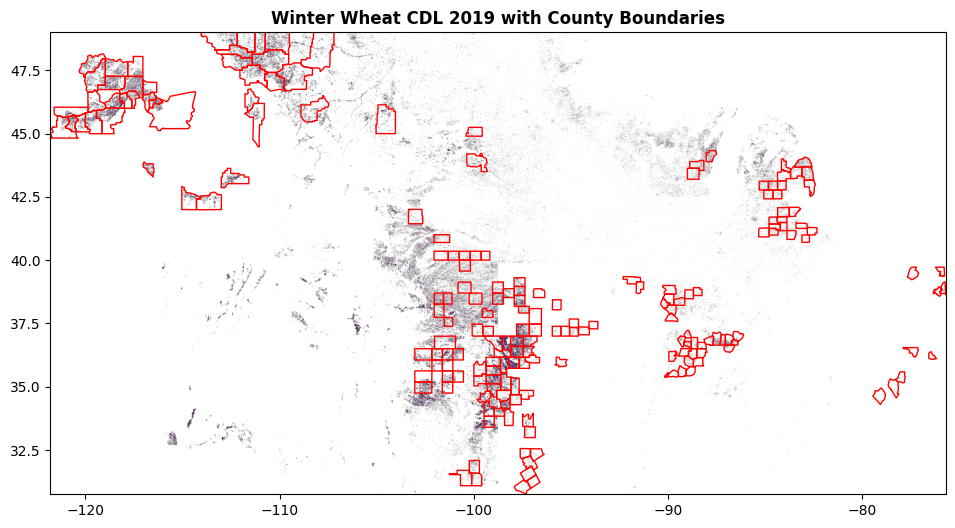

In [64]:
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt
import geopandas as gpd

# Load the raster
raster_path = r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\cdl_2019_wheat_only_500m.tif'
with rasterio.open(raster_path) as src:
    fig, ax = plt.subplots(figsize=(12, 6))
    rasterio.plot.show(src, ax=ax, title="Winter Wheat CDL 2019 with County Boundaries")
    
    # Plot reprojected counties on top
    gdf = gpd.read_file(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\top_200_filtered.geojson').to_crs(src.crs)
    gdf.plot(ax=ax, facecolor='none', edgecolor='red')
    
    plt.show()


In [69]:
import geopandas as gpd

df200_pd=df200.to_pandas()


# Load from local unzip path
us_counties = gpd.read_file(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\counties\cb_2022_us_county_5m.shp')

# Ensure FIPS matching
df200_pd['fips'] = df200_pd['fips'].astype(str).str.zfill(5)
us_counties['fips'] = us_counties['STATEFP'] + us_counties['COUNTYFP']

# Filter to top 200
top_200_geo = us_counties[us_counties['fips'].isin(df200_pd['fips'])]

# Save fixed GeoJSON
top_200_geo.to_file("top_200_fixed.geojson", driver="GeoJSON")


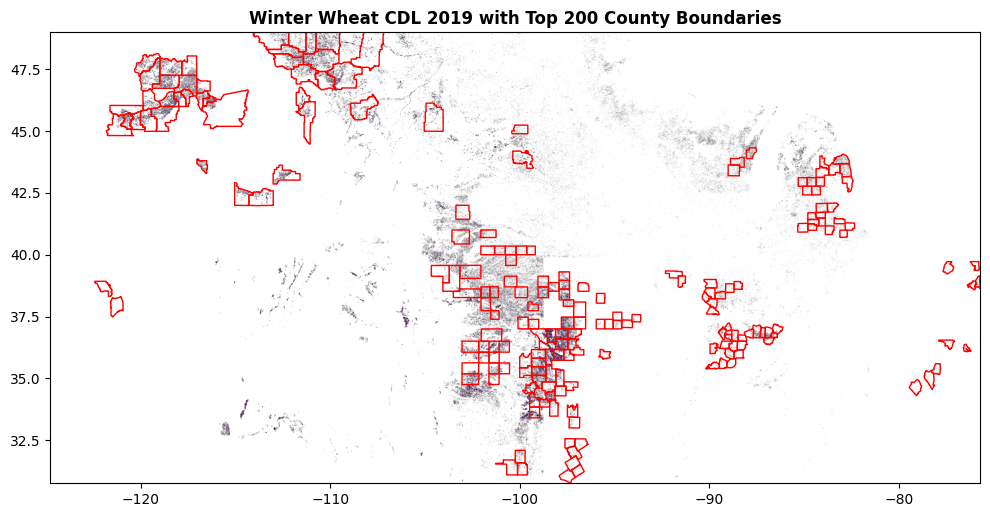

In [75]:
import geopandas as gpd
import rasterio
import rasterio.plot
import matplotlib.pyplot as plt

# Load GeoJSON
gdf = gpd.read_file(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\top_200_fixed.geojson')
gdf = gdf.to_crs("EPSG:4326")
# Load CDL raster
raster_path = r"C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\cdl_2019_wheat_only_500m.tif"
with rasterio.open(raster_path) as src:
    fig, ax = plt.subplots(figsize=(12, 6))
    rasterio.plot.show(src, ax=ax, title="Winter Wheat CDL 2019 with Top 200 County Boundaries")
    
    # Reproject counties to match raster CRS if needed
    if gdf.crs != src.crs:
        gdf = gdf.to_crs(src.crs)
    
    gdf.plot(ax=ax, facecolor='none', edgecolor='red', linewidth=1)
    plt.show()


### Getting MODIS data

#### FULL YEAR MODIS

In [3]:
import ee
import geemap
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import numpy as np
import os
from tqdm import tqdm

# === Initialize Earth Engine ===
ee.Initialize()

# === Load counties GeoJSON ===
gdf = gpd.read_file(
    r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\top_200_fixed.geojson'
).to_crs("EPSG:4326")

# === Output directory ===
root_out_dir = r"C:/Users/porter77.BYU/OneDrive - Brigham Young University/Huron/modis_npy_output"
os.makedirs(root_out_dir, exist_ok=True)

# === MODIS bands to extract ===
modis_bands = [
    'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03',
    'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07'
]

# === MODIS QA mask function ===
def mask_modis_quality(img):
    qa = img.select('StateQA')
    cloud_clear = qa.bitwiseAnd(3).lt(2)
    no_shadow = qa.bitwiseAnd(1 << 2).eq(0)
    no_snow = qa.bitwiseAnd(1 << 10).eq(0)
    no_fail = qa.bitwiseAnd(1 << 15).eq(0)
    return img.updateMask(cloud_clear.And(no_shadow).And(no_snow).And(no_fail))

# === Loop through each year ===
for year in range(2019, 2024):
    tqdm.write(f"📆 Starting year {year}")
    out_dir = os.path.join(root_out_dir, str(year))
    os.makedirs(out_dir, exist_ok=True)

    # Load CDL wheat mask
    cdl_tif_path = f"C:/Users/porter77.BYU/OneDrive - Brigham Young University/Huron/cdl_{year}_wheat_only_500m.tif"
    with rasterio.open(cdl_tif_path) as src:
        dst_crs = src.crs
        dst_transform = src.transform
        dst_shape = src.shape

    # MODIS ImageCollection for this year
    modis_year = ee.ImageCollection("MODIS/061/MOD09A1") \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .map(mask_modis_quality) \
        .select(modis_bands) \
        .map(lambda img: img.multiply(0.0001))

    # Process each county
    for idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc=f"Year {year}"):
        name = f"county_{idx}"
        geom = row['geometry']
        geom_mapping = [mapping(geom)]

        with rasterio.open(cdl_tif_path) as src:
            out_image, _ = mask(src, geom_mapping, crop=True)
            county_mask = out_image[0].astype(np.uint8)

        if county_mask.max() == 0:
            tqdm.write(f"⛔ No wheat in {name}, skipping.")
            continue

        ee_geom = ee.Geometry(mapping(geom))
        modis_clipped = modis_year.map(lambda img: img.clip(ee_geom))
        modis_list = modis_clipped.toList(modis_clipped.size())
        num_images = modis_clipped.size().getInfo()

        arrays = []

        for i in tqdm(range(num_images), desc=f"{name} ({year})", leave=False):
            try:
                img = ee.Image(modis_list.get(i))
                np_arr = geemap.ee_to_numpy(img, region=ee_geom, scale=500)

                if np_arr is None or np_arr.shape[0] == 0 or np_arr.shape[1] == 0:
                    tqdm.write(f"⚠️ Skipped image {i} (invalid shape)")
                    continue

                modis_bands_first = np_arr.transpose(2, 0, 1)  # (Bands, H, W)

                # Clip MODIS to match CDL mask dimensions
                crop_h = min(modis_bands_first.shape[1], county_mask.shape[0])
                crop_w = min(modis_bands_first.shape[2], county_mask.shape[1])
                modis_cropped = modis_bands_first[:, :crop_h, :crop_w]
                mask_cropped = county_mask[:crop_h, :crop_w]

                masked = np.where(mask_cropped == 1, modis_cropped, np.nan)
                arrays.append(masked)

            except Exception as e:
                tqdm.write(f"⚠️ Skipped image {i} in {name} ({year}) due to: {e}")
                continue

        if arrays:
            try:
                # Align all arrays to the minimum shape
                min_h = min(arr.shape[1] for arr in arrays)
                min_w = min(arr.shape[2] for arr in arrays)
                arrays_trimmed = [arr[:, :min_h, :min_w] for arr in arrays]

                tensor = np.stack(arrays_trimmed, axis=0)  # (T, Bands, H, W)
                np.save(os.path.join(out_dir, f"{name}.npy"), tensor)
            except ValueError as ve:
                tqdm.write(f"❌ Could not stack for {name}: {ve}")


📆 Starting year 2019


Year 2019:  60%|█████▉    | 119/200 [1:00:38<39:42, 29.41s/it]

⛔ No wheat in county_119, skipping.


Year 2019:  88%|████████▊ | 176/200 [1:30:12<13:11, 32.98s/it]

⛔ No wheat in county_176, skipping.


Year 2019: 100%|██████████| 200/200 [1:41:59<00:00, 30.60s/it]


📆 Starting year 2020


Year 2020:  60%|█████▉    | 119/200 [1:01:52<39:13, 29.06s/it]

⛔ No wheat in county_119, skipping.


Year 2020:  88%|████████▊ | 176/200 [1:31:13<13:00, 32.53s/it]

⛔ No wheat in county_176, skipping.


Year 2020: 100%|██████████| 200/200 [1:42:54<00:00, 30.87s/it]


📆 Starting year 2021


Year 2021:  60%|█████▉    | 119/200 [1:01:46<41:58, 31.10s/it]

⛔ No wheat in county_119, skipping.


Year 2021:  88%|████████▊ | 176/200 [1:32:39<13:29, 33.74s/it]

⛔ No wheat in county_176, skipping.


Year 2021: 100%|██████████| 200/200 [1:44:55<00:00, 31.48s/it]


📆 Starting year 2022


Year 2022:  60%|█████▉    | 119/200 [1:03:24<41:50, 30.99s/it]

⛔ No wheat in county_119, skipping.


Year 2022:  88%|████████▊ | 176/200 [1:34:33<13:35, 33.99s/it]

⛔ No wheat in county_176, skipping.


Year 2022: 100%|██████████| 200/200 [1:47:05<00:00, 32.13s/it]


📆 Starting year 2023


Year 2023:  60%|█████▉    | 119/200 [1:05:38<42:07, 31.20s/it]

⛔ No wheat in county_119, skipping.


Year 2023:  88%|████████▊ | 176/200 [1:36:59<14:08, 35.33s/it]

⛔ No wheat in county_176, skipping.


Year 2023: 100%|██████████| 200/200 [1:49:32<00:00, 32.86s/it]


#### March1-July31 MODIS (Not fixed yet, also maybe want to add august and feb?)

Monthly fixed (hopefully)

In [5]:
import ee
import geemap
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from shapely.geometry import mapping
import numpy as np
import os
from tqdm import tqdm

# === Initialize Earth Engine ===
ee.Initialize()

# === Load counties GeoJSON ===
gdf = gpd.read_file(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\top_200_fixed.geojson').to_crs("EPSG:4326")

# === Output base directory ===
root_out_dir = r"C:/Users/porter77.BYU/OneDrive - Brigham Young University/Huron/modis_npy_output_monthly"
os.makedirs(root_out_dir, exist_ok=True)

# === MODIS bands to extract ===
modis_bands = [
    'sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03',
    'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07'
]

# === Cloud/snow/shadow/QA mask ===
def mask_modis_quality(img):
    qa = img.select('StateQA')
    cloud_clear = qa.bitwiseAnd(3).lt(2)
    no_shadow = qa.bitwiseAnd(1 << 2).eq(0)
    no_snow = qa.bitwiseAnd(1 << 10).eq(0)
    no_fail = qa.bitwiseAnd(1 << 15).eq(0)
    return img.updateMask(cloud_clear.And(no_shadow).And(no_snow).And(no_fail))

# === Loop through each year ===
for year in range(2019, 2024):
    tqdm.write(f"📆 Starting year {year}")

    # === Load CDL wheat mask raster ===
    cdl_tif_path = f"C:/Users/porter77.BYU/OneDrive - Brigham Young University/Huron/cdl_{year}_wheat_only_500m.tif"

    # === Process each county ===
    for idx, row in tqdm(gdf.iterrows(), total=len(gdf), desc=f"Year {year}"):
        name = f"county_{idx}"
        geom = row['geometry']
        geom_mapping = [mapping(geom)]

        # Crop CDL mask to county geometry
        with rasterio.open(cdl_tif_path) as src:
            out_image, _ = mask(src, geom_mapping, crop=True)
            county_mask = out_image[0].astype(np.uint8)

        if county_mask.max() == 0:
            tqdm.write(f"⛔ No wheat in {name}, skipping.")
            continue

        ee_geom = ee.Geometry(mapping(geom))

        for month in range(3, 8):  # March to July
            start_date = f"{year}-{month:02d}-01"
            end_date = f"{year}-{month+1:02d}-01" if month < 7 else f"{year}-07-31"

            out_dir = os.path.join(root_out_dir, str(year), f"{month:02d}")
            os.makedirs(out_dir, exist_ok=True)

            modis_month = ee.ImageCollection("MODIS/061/MOD09A1") \
                .filterDate(start_date, end_date) \
                .map(mask_modis_quality) \
                .select(modis_bands) \
                .map(lambda img: img.multiply(0.0001)) \
                .map(lambda img: img.clip(ee_geom))

            modis_list = modis_month.toList(modis_month.size())
            num_images = modis_month.size().getInfo()
            arrays = []

            for i in tqdm(range(num_images), desc=f"{name} ({year}-{month:02d})", leave=False):
                try:
                    img = ee.Image(modis_list.get(i))
                    np_arr = geemap.ee_to_numpy(img, region=ee_geom, scale=500)

                    if np_arr is None or np_arr.shape[0] == 0 or np_arr.shape[1] == 0:
                        tqdm.write(f"⚠️ Skipped image {i} (invalid shape)")
                        continue

                    modis_bands_first = np_arr.transpose(2, 0, 1)  # (Bands, H, W)

                    # Simple cropping to align with CDL mask
                    crop_h = min(modis_bands_first.shape[1], county_mask.shape[0])
                    crop_w = min(modis_bands_first.shape[2], county_mask.shape[1])
                    modis_cropped = modis_bands_first[:, :crop_h, :crop_w]
                    mask_cropped = county_mask[:crop_h, :crop_w]

                    masked = np.where(mask_cropped == 1, modis_cropped, np.nan)
                    arrays.append(masked)

                except Exception as e:
                    tqdm.write(f"⚠️ Skipped image {i} in {name} ({year}-{month:02d}) due to: {e}")
                    continue

            if arrays:
                try:
                    min_h = min(arr.shape[1] for arr in arrays)
                    min_w = min(arr.shape[2] for arr in arrays)
                    arrays_trimmed = [arr[:, :min_h, :min_w] for arr in arrays]
                    tensor = np.stack(arrays_trimmed, axis=0)  # (T, B, H, W)
                    np.save(os.path.join(out_dir, f"{name}.npy"), tensor)
                except ValueError as ve:
                    tqdm.write(f"❌ Could not stack for {name} in {year}-{month:02d}: {ve}")


📆 Starting year 2019


Year 2019:  60%|█████▉    | 119/200 [24:40<15:49, 11.72s/it]

⛔ No wheat in county_119, skipping.


Year 2019:  88%|████████▊ | 176/200 [36:27<05:16, 13.20s/it]

⛔ No wheat in county_176, skipping.


Year 2019: 100%|██████████| 200/200 [41:11<00:00, 12.36s/it]


📆 Starting year 2020


Year 2020:  60%|█████▉    | 119/200 [24:25<15:40, 11.61s/it]

⛔ No wheat in county_119, skipping.


Year 2020:  88%|████████▊ | 176/200 [36:14<05:47, 14.48s/it]

⛔ No wheat in county_176, skipping.


Year 2020: 100%|██████████| 200/200 [40:54<00:00, 12.27s/it]


📆 Starting year 2021


Year 2021:  60%|█████▉    | 119/200 [24:22<15:03, 11.15s/it]

⛔ No wheat in county_119, skipping.


Year 2021:  88%|████████▊ | 176/200 [36:11<05:17, 13.21s/it]

⛔ No wheat in county_176, skipping.


Year 2021: 100%|██████████| 200/200 [40:52<00:00, 12.26s/it]


📆 Starting year 2022


Year 2022:  60%|█████▉    | 119/200 [24:40<15:51, 11.75s/it]

⛔ No wheat in county_119, skipping.


Year 2022:  88%|████████▊ | 176/200 [36:25<05:17, 13.22s/it]

⛔ No wheat in county_176, skipping.


Year 2022: 100%|██████████| 200/200 [41:01<00:00, 12.31s/it]


📆 Starting year 2023


Year 2023:  60%|█████▉    | 119/200 [24:23<15:49, 11.72s/it]

⛔ No wheat in county_119, skipping.


Year 2023:  88%|████████▊ | 176/200 [36:13<05:13, 13.06s/it]

⛔ No wheat in county_176, skipping.


Year 2023: 100%|██████████| 200/200 [40:54<00:00, 12.27s/it]


#### Clean MODIS

In [ ]:
import numpy as np
import tensorflow as tf
import os

# === Paths ===
input_dir = r"C:/Users/porter77.BYU/OneDrive - Brigham Young University/Huron/modis_npy_output"  #where my modis is saved
standardized_dir = r"C:/Users/porter77.BYU/OneDrive - Brigham Young University/Huron/modis_numpy_standardized"
os.makedirs(standardized_dir, exist_ok=True)

# === Target size ===
TARGET_T = 46
HEIGHT, WIDTH = 128, 128

# === Process each .npy file ===
for root, dirs, files in os.walk(input_dir):
    for filename in files:
        if filename.endswith(".npy"):
            input_path = os.path.join(root, filename)
            rel_path = os.path.relpath(input_path, input_dir)
            output_path = os.path.join(standardized_dir, rel_path)

            os.makedirs(os.path.dirname(output_path), exist_ok=True)

            # Load array and fill NaNs with zeros
            arr = np.load(input_path)  # (T, C, H, W)
            arr = np.nan_to_num(arr, nan=0.0)
            arr = np.transpose(arr, (0, 2, 3, 1))  # (T, H, W, C)

            # Resize each frame
            resized = tf.stack([
                tf.image.resize(frame, [HEIGHT, WIDTH], method='bilinear')
                for frame in arr
            ])

            # Pad time dimension if needed
            t = resized.shape[0]
            if t < TARGET_T:
                pad_t = TARGET_T - t
                padding = tf.zeros((pad_t, HEIGHT, WIDTH, resized.shape[-1]), dtype=resized.dtype)
                resized = tf.concat([resized, padding], axis=0)

            # Final shape check
            if resized.shape[0] != TARGET_T:
                raise ValueError(f"❌ Unexpected shape {resized.shape} in file: {input_path}")

            # Convert to NumPy
            arr_np = resized.numpy().astype(np.float32)

            # Compute mean/std only over non-zero pixels
            valid_mask = arr_np != 0
            valid_values = arr_np[valid_mask]

            if valid_values.size > 0:
                mean = valid_values.mean()
                std = valid_values.std() + 1e-6  # avoid divide-by-zero
                standardized = (arr_np - mean) / std
                standardized[~valid_mask] = 0.0  # keep padded areas at 0
            else:
                standardized = arr_np  # fallback: no valid pixels

            # Save standardized version
            np.save(output_path, standardized)
            print(f"✅ Saved {rel_path} | standardized: shape={standardized.shape}")


✅ Saved 2019\county_0.npy | standardized: shape=(46, 128, 128, 7)
✅ Saved 2019\county_1.npy | standardized: shape=(46, 128, 128, 7)
✅ Saved 2019\county_10.npy | standardized: shape=(46, 128, 128, 7)
✅ Saved 2019\county_100.npy | standardized: shape=(46, 128, 128, 7)
✅ Saved 2019\county_101.npy | standardized: shape=(46, 128, 128, 7)
✅ Saved 2019\county_102.npy | standardized: shape=(46, 128, 128, 7)
✅ Saved 2019\county_103.npy | standardized: shape=(46, 128, 128, 7)
✅ Saved 2019\county_104.npy | standardized: shape=(46, 128, 128, 7)
✅ Saved 2019\county_105.npy | standardized: shape=(46, 128, 128, 7)
✅ Saved 2019\county_106.npy | standardized: shape=(46, 128, 128, 7)
✅ Saved 2019\county_107.npy | standardized: shape=(46, 128, 128, 7)
✅ Saved 2019\county_108.npy | standardized: shape=(46, 128, 128, 7)
✅ Saved 2019\county_109.npy | standardized: shape=(46, 128, 128, 7)
✅ Saved 2019\county_11.npy | standardized: shape=(46, 128, 128, 7)
✅ Saved 2019\county_110.npy | standardized: shape=(46,

#### Adding NDVI, EVI, and NWDI to the MODIS data so i have 10 channels (FULL YEAR)

In [20]:
import numpy as np
import tensorflow as tf
import os

# === Paths ===
input_dir = r"C:/Users/porter77.BYU/OneDrive - Brigham Young University/Huron/modis_npy_output"
standardized_dir = r"C:/Users/porter77.BYU/OneDrive - Brigham Young University/Huron/modis10_numpy_standardized"
os.makedirs(standardized_dir, exist_ok=True)

# === Target size ===
TARGET_T = 46
HEIGHT, WIDTH = 128, 128

# === Process each .npy file ===
for root, dirs, files in os.walk(input_dir):
    for filename in files:
        if filename.endswith(".npy"):
            input_path = os.path.join(root, filename)
            rel_path = os.path.relpath(input_path, input_dir)
            output_path = os.path.join(standardized_dir, rel_path)
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

            # Load array and fill NaNs with zeros
            arr = np.load(input_path)  # shape (T, C, H, W)
            arr = np.nan_to_num(arr, nan=0.0)
            arr = np.transpose(arr, (0, 2, 3, 1))  # (T, H, W, C)

            # Extract bands for vegetation indices
            red   = arr[..., 0]
            nir   = arr[..., 1]
            blue  = arr[..., 2]
            green = arr[..., 3]

            # Compute vegetation indices
            ndvi = (nir - red) / (nir + red + 1e-6)
            evi  = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)
            ndwi = (green - nir) / (green + nir + 1e-6)

            # Expand and stack
            ndvi = np.expand_dims(ndvi, axis=-1)
            evi  = np.expand_dims(evi, axis=-1)
            ndwi = np.expand_dims(ndwi, axis=-1)
            arr = np.concatenate([arr, ndvi, evi, ndwi], axis=-1)  # shape (T, H, W, 10)

            # Resize each frame
            resized = tf.stack([
                tf.image.resize(frame, [HEIGHT, WIDTH], method='bilinear')
                for frame in arr
            ])

            # Pad time if needed
            t = resized.shape[0]
            if t < TARGET_T:
                pad_t = TARGET_T - t
                padding = tf.zeros((pad_t, HEIGHT, WIDTH, resized.shape[-1]), dtype=resized.dtype)
                resized = tf.concat([resized, padding], axis=0)

            if resized.shape[0] != TARGET_T:
                raise ValueError(f"❌ Unexpected shape {resized.shape} in file: {input_path}")

            arr_np = resized.numpy().astype(np.float32)

            # === Normalize per channel to [-1, 1] ===
            normalized = np.empty_like(arr_np, dtype=np.float32)
            for c in range(arr_np.shape[-1]):
                band = arr_np[..., c]
                valid_mask = band != 0
                valid_values = band[valid_mask]

                if valid_values.size > 0:
                    min_val = valid_values.min()
                    max_val = valid_values.max()
                    range_val = max_val - min_val + 1e-6  # avoid divide-by-zero
                    band_norm = 2 * (band - min_val) / range_val - 1
                    band_norm[~valid_mask] = 0.0  # keep padding as 0
                    normalized[..., c] = band_norm
                else:
                    normalized[..., c] = band  # fallback

            # Save output
            np.save(output_path, normalized)
            print(f"✅ Saved {rel_path} | shape={normalized.shape}")


✅ Saved 2019\county_0.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_1.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_10.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_100.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_101.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_102.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_103.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_104.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_105.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_106.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_107.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_108.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_109.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_11.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_110.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_111.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_112.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\county_113.npy | shape=(46, 128, 128, 10)
✅ Saved 2019\cou

#### Getting 10 channels for march-july data (Not fixed yet)

In [16]:
import numpy as np
import tensorflow as tf
import os

# === Paths ===
input_dir = r"C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\modis_npy_output_monthly"
output_dir = r"C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\modis10_monthly_standardized"
os.makedirs(output_dir, exist_ok=True)

# === Target shape settings ===
TARGET_T = 4
HEIGHT, WIDTH = 128, 128

# === Walk through all year/month folders ===
for year in os.listdir(input_dir):
    year_path = os.path.join(input_dir, year)
    if not os.path.isdir(year_path):
        continue

    for month in os.listdir(year_path):
        month_path = os.path.join(year_path, month)
        if not os.path.isdir(month_path):
            continue

        for filename in os.listdir(month_path):
            if not filename.endswith(".npy"):
                continue

            input_path = os.path.join(month_path, filename)
            rel_path = os.path.relpath(input_path, input_dir)
            output_path = os.path.join(output_dir, rel_path)
            os.makedirs(os.path.dirname(output_path), exist_ok=True)

            # === Load and preprocess ===
            arr = np.load(input_path)  # shape (T, C, H, W)
            arr = np.nan_to_num(arr, nan=0.0)
            arr = np.transpose(arr, (0, 2, 3, 1))  # (T, H, W, C)

            # === Vegetation Indices ===
            red   = arr[..., 0]
            nir   = arr[..., 1]
            blue  = arr[..., 2]
            green = arr[..., 3]

            ndvi = (nir - red) / (nir + red + 1e-6)
            evi  = 2.5 * (nir - red) / (nir + 6 * red - 7.5 * blue + 1)
            ndwi = (green - nir) / (green + nir + 1e-6)

            ndvi = np.expand_dims(ndvi, axis=-1)
            evi  = np.expand_dims(evi, axis=-1)
            ndwi = np.expand_dims(ndwi, axis=-1)
            arr = np.concatenate([arr, ndvi, evi, ndwi], axis=-1)  # shape (T, H, W, 10)

            # === Resize to 128x128 ===
            resized = tf.stack([
                tf.image.resize(frame, [HEIGHT, WIDTH], method='bilinear')
                for frame in arr
            ])

            # === Time padding ===
            t = resized.shape[0]
            if t < TARGET_T:
                pad_t = TARGET_T - t
                padding = tf.zeros((pad_t, HEIGHT, WIDTH, resized.shape[-1]), dtype=resized.dtype)
                resized = tf.concat([resized, padding], axis=0)

            if resized.shape[0] != TARGET_T:
                raise ValueError(f"❌ Unexpected shape {resized.shape} in file: {input_path}")

            arr_np = resized.numpy().astype(np.float32)

            # === Normalize to [-1, 1] ===
            normalized = np.empty_like(arr_np, dtype=np.float32)
            for c in range(arr_np.shape[-1]):
                band = arr_np[..., c]
                valid_mask = band != 0
                valid_values = band[valid_mask]

                if valid_values.size > 0:
                    min_val = valid_values.min()
                    max_val = valid_values.max()
                    range_val = max_val - min_val + 1e-6
                    band_norm = 2 * (band - min_val) / range_val - 1
                    band_norm[~valid_mask] = 0.0
                    normalized[..., c] = band_norm
                else:
                    normalized[..., c] = band

            # === Save output ===
            np.save(output_path, normalized)
            print(f"✅ Saved {rel_path} | shape={normalized.shape}")


✅ Saved 2019\03\county_0.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_1.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_10.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_100.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_101.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_102.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_103.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_104.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_105.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_106.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_107.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_108.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_109.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_11.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_110.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_111.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_112.npy | shape=(4, 128, 128, 10)
✅ Saved 2019\03\county_113.npy | shap

### Getting Other data (X, y, daymet, ema)

#### Get y

In [6]:
import geopandas as gpd
gdf=gpd.read_file(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\top_200_fixed.geojson')
gdf

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,GEOID,NAME,NAMELSAD,STUSPS,STATE_NAME,LSAD,ALAND,AWATER,fips,geometry
0,40,093,01101831,0500000US40093,40093,Major,Major County,OK,Oklahoma,06,2473438557,7651009,40093,"POLYGON ((-98.96033 36.50691, -98.8437 36.5063..."
1,30,051,01720036,0500000US30051,30051,Liberty,Liberty County,MT,Montana,06,3703651373,44411471,30051,"POLYGON ((-111.40902 48.21954, -111.27531 48.2..."
2,17,189,01785150,0500000US17189,17189,Washington,Washington County,IL,Illinois,06,1457120178,3386079,17189,"POLYGON ((-89.70424 38.41578, -89.69676 38.425..."
3,48,139,01383856,0500000US48139,48139,Ellis,Ellis County,TX,Texas,06,2423586107,41965719,48139,"POLYGON ((-97.08706 32.5493, -97.08509 32.5492..."
4,21,213,00516953,0500000US21213,21213,Simpson,Simpson County,KY,Kentucky,06,606511222,5930956,21213,"POLYGON ((-86.76329 36.64891, -86.75134 36.727..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,40,129,01101852,0500000US40129,40129,Roger Mills,Roger Mills County,OK,Oklahoma,06,2955524813,13688537,40129,"POLYGON ((-100.0004 35.88123, -99.97211 35.888..."
196,16,069,00399394,0500000US16069,16069,Nez Perce,Nez Perce County,ID,Idaho,06,2197139835,21252880,16069,"POLYGON ((-117.06278 46.36529, -117.06128 46.3..."
197,26,063,01622974,0500000US26063,26063,Huron,Huron County,MI,Michigan,06,2165275137,3369019054,26063,"MULTIPOLYGON (((-83.45224 43.85635, -83.4474 4..."
198,20,021,00484980,0500000US20021,20021,Cherokee,Cherokee County,KS,Kansas,06,1521791029,8951464,20021,"POLYGON ((-95.07517 37.33994, -94.90482 37.339..."


In [7]:
import polars as pl

natl=pl.read_csv(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\winter_wheat_natl.csv')


# Add FIPS column by zero-padding ANSI codes and concatenating
natl = natl.with_columns([
    pl.col("State ANSI").cast(str).str.zfill(2).alias("State_FIPS"),
    pl.col("County ANSI").cast(str).str.zfill(3).alias("County_FIPS"),
])

natl = natl.with_columns([
    (pl.col("State_FIPS") + pl.col("County_FIPS")).alias("fips")
])


natl=natl.select(['Year','fips','Value'])
natl=natl.rename({'Value':'yield'})

natl=natl.to_pandas()
natl

,Year,fips,yield
0,2024,17115,93.5
1,2024,17125,91.2
2,2024,17129,91.9
3,2024,17143,96.6
4,2024,17203,82.6
...,...,...,...
48385,1994,56009,30.0
48386,1994,56015,25.9
48387,1994,56021,22.4
48388,1994,56027,23.0


In [8]:
import pandas as pd
valid_fips=pd.DataFrame(gdf['fips'])
valid_fips['Index']=valid_fips.index
valid_fips

,fips,Index
0,40093,0
1,30051,1
2,17189,2
3,48139,3
4,21213,4
...,...,...
195,40129,195
196,16069,196
197,26063,197
198,20021,198


In [9]:
yields = valid_fips.merge(natl, on=['fips'], how='left')
yields = yields.dropna()
yields = yields.sort_values(by=['Year', 'Index'], ascending=True)
yields = yields[(yields['Year'] > 2018) & (yields['Year'] < 2024)]

yields = yields[~yields['Index'].isin([119, 176])]
yields

,fips,Index,Year,yield
4,40093,0,2019,43.5
32,30051,1,2019,39.0
78,17189,2,2019,69.4
108,48139,3,2019,45.5
138,21213,4,2019,76.2
...,...,...,...,...
6277,40129,195,2023,30.3
6305,16069,196,2023,78.0
6347,26063,197,2023,105.9
6377,20021,198,2023,79.9


In [10]:
y=yields['yield']

#### Get X

In [1]:
import numpy as np
import os

# Root directory where resized MODIS files are organized by year
data_dir = r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\modis10_numpy_standardized'  # or modis_numpy_standardized
X_list = []

# Loop through all year subfolders
for year_folder in sorted(os.listdir(data_dir)):
    year_path = os.path.join(data_dir, year_folder)
    if os.path.isdir(year_path):
        for fname in sorted(os.listdir(year_path)):
            if fname.endswith(".npy"):
                full_path = os.path.join(year_path, fname)
                arr = np.load(full_path)  # Shape: (46, 128, 128, 7 or 10)
                X_list.append(arr)

# Stack into a single 5D array
X = np.stack(X_list, axis=0)  # Shape: (N, 46, 128, 128, 7 or 10)
print("✅ Final input shape:", X.shape)

# #divide by max of y
# y=y/160

✅ Final input shape: (990, 46, 128, 128, 10)


In [12]:
np.save(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_10.npy',arr=X)

In [3]:
X = np.load(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_10.npy', mmap_mode='r')


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [ ]:
# np.save(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_train.npy',arr=X_train)
# np.save(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_train.npy',arr=y_train)
# np.save(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_val.npy',arr=X_val)
# np.save(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_val.npy',arr=y_val)
# np.save(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X.npy',arr=X)



np.save(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_train_10.npy',arr=X_train)
np.save(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_train.npy',arr=y_train) # i ruined y_train, need to get it back again if i want ot goto 7 bands
np.save(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_val_10.npy',arr=X_val)
np.save(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\y_val_10.npy',arr=y_val)


#### Get Daymet

In [ ]:
import requests
import pandas as pd
import io
import matplotlib.pyplot as plt

# === Parameters ===
lat = 43.1
lon = -85.3
vars = "tmax,tmin"
years = "2012,2013"

# === Build Daymet API URL ===
url = (
    f"https://daymet.ornl.gov/single-pixel/api/data"
    f"?lat={lat}&lon={lon}&vars={vars}&years={years}"
)

# === Get CSV from the API ===
response = requests.get(url)
response.raise_for_status()  # ensure it worked

# === Read CSV into Pandas ===
df = pd.read_csv(io.StringIO(response.text), skiprows=6)


In [ ]:
df

,year,yday,tmax (deg c),tmin (deg c)
0,2012,1,4.90,-1.34
1,2012,2,-1.56,-7.45
2,2012,3,-3.52,-10.76
3,2012,4,2.22,-9.42
4,2012,5,6.52,-6.82
...,...,...,...,...
725,2013,361,2.52,-6.34
726,2013,362,7.19,-4.34
727,2013,363,4.28,-5.23
728,2013,364,-6.63,-11.57


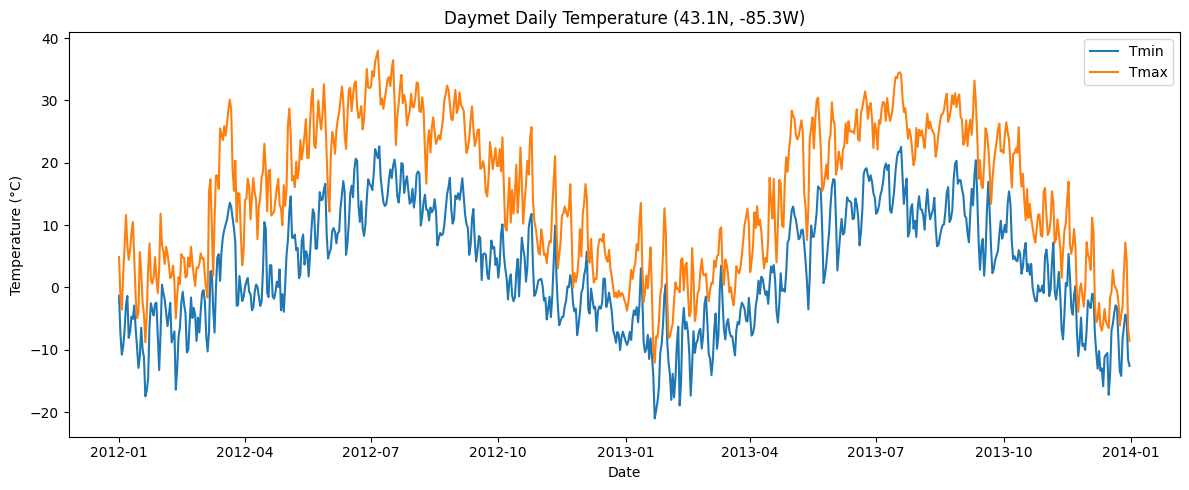

In [ ]:

# === Convert year + yday to datetime ===
df["date"] = pd.to_datetime(df["year"].astype(str) + df["yday"].astype(str), format="%Y%j")

# === Plot the temperatures ===
plt.figure(figsize=(12, 5))
plt.plot(df["date"], df["tmin (deg c)"], label="Tmin")
plt.plot(df["date"], df["tmax (deg c)"], label="Tmax")
plt.xlabel("Date")
plt.ylabel("Temperature (°C)")
plt.title("Daymet Daily Temperature (43.1N, -85.3W)")
plt.legend()
plt.tight_layout()
plt.show()



In [ ]:
import geopandas as gpd
import requests
import pandas as pd
import os
import time
from shapely.geometry import Point

# === CONFIGURATION ===
shape_path = r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\top_200_fixed.geojson'
# === Load and reproject to get accurate centroids ===
gdf = gpd.read_file(shape_path)
gdf["county_id"] = gdf.index  # Or use e.g., gdf["FIPS"] if present

# Reproject to Albers Equal Area (EPSG:5070) for accurate centroid calculation
gdf_proj = gdf.to_crs("EPSG:5070")
gdf_proj["centroid"] = gdf_proj.geometry.centroid

# Convert centroids back to WGS84 for API use
gdf["centroid"] = gdf_proj["centroid"].to_crs("EPSG:4326")


In [ ]:
from shapely.geometry import Point
import random
import time
import geopandas as gpd
import pandas as pd
import requests
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor, as_completed
from io import StringIO
import os

# === Config ===
num_points = 200
max_workers = 10
variables = "tmin,tmax,prcp,srad,vp,swe,dayl"
years = "2019,2020,2021,2022,2023"
output_dir = "daymet_outputs"
os.makedirs(output_dir, exist_ok=True)

# Column renaming map for Daymet variables
col_rename_map = {
    "tmin (deg c)": "tmin_c",
    "tmax (deg c)": "tmax_c",
    "prcp (mm/day)": "prcp_mm",
    "srad (W/m^2)": "srad_wm2",
    "vp (Pa)": "vp_pa",
    "swe (kg/m^2)": "swe_kgm2",
    "dayl (s)": "dayl_s"
}

def generate_random_points(polygon, num_points):
    minx, miny, maxx, maxy = polygon.bounds
    points = []
    while len(points) < num_points:
        p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(p):
            points.append(p)
    return points

def fetch_daymet_single_point(lat, lon):
    try:
        url = (
            f"https://daymet.ornl.gov/single-pixel/api/data"
            f"?lat={lat}&lon={lon}&measuredParams={variables}&year={years}"
        )
        r = requests.get(url, timeout=30)
        r.raise_for_status()

        lines = r.text.splitlines()
        data_start_idx = next(i for i, line in enumerate(lines) if line.startswith("year,"))
        cleaned_csv = "\n".join(lines[data_start_idx:])
        df = pd.read_csv(StringIO(cleaned_csv))
        df["date"] = pd.to_datetime(df["year"].astype(str) + df["yday"].astype(str), format="%Y%j")
        df = df[["date"] + list(col_rename_map.keys())]
        return df
    except Exception as e:
        print(f"⚠️ Point failed ({lat}, {lon}): {e}")
        return None

# === Download and aggregate ===
all_dfs = []

for i, row in tqdm(gdf.iterrows(), total=len(gdf)):
    county_id = row["county_id"]
    polygon = row["geometry"]
    points = generate_random_points(polygon, num_points)

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(fetch_daymet_single_point, pt.y, pt.x) for pt in points]
        dfs = [f.result() for f in as_completed(futures) if f.result() is not None]

    if dfs:
        df_cat = pd.concat(dfs).groupby("date").mean().reset_index()
        df_cat = df_cat.rename(columns=col_rename_map)
        df_cat["county_id"] = county_id
        all_dfs.append(df_cat)

        # Save individual county CSV
        county_path = os.path.join(output_dir, f"daymet_county_{county_id}.csv")
        df_cat.to_csv(county_path, index=False)

# === Save aggregate file ===
if all_dfs:
    final_df = pd.concat(all_dfs)
    final_df.to_csv(os.path.join(output_dir, "daymet_avg_by_county.csv"), index=False)
    print("✅ Saved all to 'daymet_outputs/'")
else:
    print("❌ No data collected.")


 44%|████▍     | 89/200 [1:13:28<1:29:46, 48.53s/it]

⚠️ Point failed (39.48141045959115, -75.92246916914678): 400 Client Error: BAD REQUEST for url: https://daymet.ornl.gov/single-pixel/api/data?lat=39.48141045959115&lon=-75.92246916914678&measuredParams=tmin,tmax,prcp,srad,vp,swe,dayl&year=2019,2020,2021,2022,2023


 47%|████▋     | 94/200 [1:17:21<1:22:07, 46.49s/it]

⚠️ Point failed (38.827526342219315, -76.29215999417094): 400 Client Error: BAD REQUEST for url: https://daymet.ornl.gov/single-pixel/api/data?lat=38.827526342219315&lon=-76.29215999417094&measuredParams=tmin,tmax,prcp,srad,vp,swe,dayl&year=2019,2020,2021,2022,2023
⚠️ Point failed (38.75801831335271, -76.30203568203676): 400 Client Error: BAD REQUEST for url: https://daymet.ornl.gov/single-pixel/api/data?lat=38.75801831335271&lon=-76.30203568203676&measuredParams=tmin,tmax,prcp,srad,vp,swe,dayl&year=2019,2020,2021,2022,2023
⚠️ Point failed (38.8131729949905, -76.20152018389241): 400 Client Error: BAD REQUEST for url: https://daymet.ornl.gov/single-pixel/api/data?lat=38.8131729949905&lon=-76.20152018389241&measuredParams=tmin,tmax,prcp,srad,vp,swe,dayl&year=2019,2020,2021,2022,2023
⚠️ Point failed (38.78795032936696, -76.20843790007517): 400 Client Error: BAD REQUEST for url: https://daymet.ornl.gov/single-pixel/api/data?lat=38.78795032936696&lon=-76.20843790007517&measuredParams=tmin,t

100%|██████████| 200/200 [2:41:48<00:00, 48.54s/it]  


✅ Saved all to 'daymet_outputs/'


#### Cleaning Daymet

In [ ]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# === Config ===
input_dir = r"C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\historical context\daymet_outputs"
output_dir = r"C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\historical context\daymet_weather_arrays"
os.makedirs(output_dir, exist_ok=True)

weather_features = ["tmin_c", "tmax_c", "prcp_mm", "srad_wm2", "vp_pa", "swe_kgm2", "dayl_s"]

# Loop through all files
for file_name in os.listdir(input_dir):
    if not file_name.endswith(".csv") or not file_name.startswith("daymet_county_"):
        continue

    file_path = os.path.join(input_dir, file_name)
    df = pd.read_csv(file_path)

    # Parse date and extract year
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
    df["year"] = df["date"].dt.year

    # Get county ID from column
    county_id = df["county_id"].iloc[0]

    # Loop over each year
    for year, year_df in df.groupby("year"):
        year_df = year_df.sort_values("date")

        if len(year_df) < 365:
            print(f"⚠️ Skipping {county_id}, {year} — incomplete year ({len(year_df)} days)")
            continue

        try:
            # Extract and normalize weather variables
            X = year_df[weather_features].to_numpy()
            X_scaled = StandardScaler().fit_transform(X)

            # Save to .npy
            out_path = os.path.join(output_dir, f"weather_{county_id}_{year}.npy")
            np.save(out_path, X_scaled)
        except Exception as e:
            print(f"❌ Error processing {county_id}, {year}: {e}")


In [ ]:
import os
import numpy as np

# === Config ===
input_dir = r"C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\historical context\daymet_weather_arrays"
output_path = r"C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\historical context\X_weather_stacked.npy"

X_weather = []
index_keys = []

excluded_counties = {119, 176}

for fname in os.listdir(input_dir):
    if not fname.endswith(".npy") or not fname.startswith("weather_"):
        continue

    fpath = os.path.join(input_dir, fname)
    arr = np.load(fpath)

    # Check shape and trim if needed
    if arr.shape[0] == 366:
        arr = arr[:365]
    elif arr.shape[0] < 365:
        print(f"⚠️ Skipping {fname}: only {arr.shape[0]} days")
        continue

    # Extract county and year from filename
    try:
        base = os.path.splitext(fname)[0]  # e.g., 'weather_12_2020'
        _, county_id, year = base.split("_")
        county_id = int(county_id)
        year = int(year)

        if county_id in excluded_counties:
            print(f"⏭️ Skipping excluded county: {county_id}, {year}")
            continue

        index_keys.append((county_id, year))
        X_weather.append(arr)

    except Exception as e:
        print(f"❌ Failed to parse {fname}: {e}")
        continue

# Stack into 3D array
X_weather = np.stack(X_weather)
np.save(output_path, X_weather)
print(f"✅ Stacked weather data saved to: {output_path}")

# Save index keys (optional)
np.save(os.path.join(input_dir, "index_keys.npy"), np.array(index_keys, dtype=object))




⏭️ Skipping excluded county: 119, 2019
⏭️ Skipping excluded county: 119, 2020
⏭️ Skipping excluded county: 119, 2021
⏭️ Skipping excluded county: 119, 2022
⏭️ Skipping excluded county: 119, 2023
⏭️ Skipping excluded county: 176, 2019
⏭️ Skipping excluded county: 176, 2020
⏭️ Skipping excluded county: 176, 2021
⏭️ Skipping excluded county: 176, 2022
⏭️ Skipping excluded county: 176, 2023
✅ Stacked weather data saved to: C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\historical context\X_weather_stacked.npy


In [10]:
from sklearn.model_selection import train_test_split

X_train_w, X_val_w = train_test_split(
    X_weather,test_size=0.2, random_state=42)

In [ ]:
np.save(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_train_w.npy',arr=X_train_w)
np.save(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_val_w.npy',arr=X_val_w)


OSError: [Errno 22] Invalid argument: 'C:\\Users\\porter77.BYU\\OneDrive - Brigham Young University\\Huron\\yield_prediction\\Training Data\\X_train_w.npy'

#### EMA from previous year as an input

In [14]:
#read in natl file for wheat
#filter to only top 200 geojson counties
#get ema time series for 19-23
#stack all 200 of 2019 and then do 2020 then do 2021 etc

wheat_natl=pl.read_csv(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\winter_wheat_natl.csv')

wheat_natl=wheat_natl.filter(pl.col('Program')=='SURVEY')
wheat_natl=wheat_natl.select(['Year','County','State ANSI','County ANSI','Value'])


wheat_natl=wheat_natl.with_columns(
   (( pl.col('State ANSI').cast(pl.Utf8).str.zfill(2)) +
   (pl.col('County ANSI').cast(pl.Utf8).str.zfill(3)))
   .alias('fips')
)
wheat_natl=wheat_natl.rename({'Value':'yield'})

#get rid of duplicates
wheat_natl = (
    wheat_natl
    .group_by(['fips', 'Year'])
    .agg([
        pl.col('yield').mean().alias('yield')
    ])
)


fips_count=((wheat_natl.group_by(pl.col('fips')).agg(pl.col('Year').count())))
fips_count=fips_count.rename({'Year':'fips_count'})


##merge
wheat_natl=wheat_natl.join(fips_count,on='fips')
wheat_natl=wheat_natl.sort(['Year','fips'],descending=True)






In [15]:
wheat_natl=wheat_natl.filter(pl.col('fips_count')>21)
wheat_natl['fips'].n_unique()
wheat_natl_pd=wheat_natl.to_pandas()

In [16]:


#read in top_200 fixed
gdf=gpd.read_file(r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\top_200_fixed.geojson')
good_fips=gdf['fips']
good_fips=pd.DataFrame(good_fips)
good_fips['Index']=good_fips.index
good_fips



,fips,Index
0,40093,0
1,30051,1
2,17189,2
3,48139,3
4,21213,4
...,...,...
195,40129,195
196,16069,196
197,26063,197
198,20021,198


In [17]:

merged=good_fips.merge(wheat_natl_pd,on=['fips'],how='inner')
merged

,fips,Index,Year,yield,fips_count
0,40093,0,2023,22.7,28
1,40093,0,2022,26.0,28
2,40093,0,2021,44.9,28
3,40093,0,2020,44.2,28
4,40093,0,2019,43.5,28
...,...,...,...,...,...
5832,26037,199,1998,55.0,30
5833,26037,199,1997,65.0,30
5834,26037,199,1996,33.0,30
5835,26037,199,1995,64.0,30


In [18]:
#read in natl file for wheat
#filter to only top 200 geojson counties
#get ema time series for 19-23
#stack all 200 of 2019 and then do 2020 then do 2021 etc

#change my merged to this so i dont have to change the code below
wheat_natl=pl.DataFrame(merged)

emas = []
fips_list = []
year_list=[]
index_list=[]

alpha = .2  # EMA smoothing factor

for county in wheat_natl['fips'].unique():
    for year in range(2019,2024):
        sub = (
            wheat_natl.filter(
                (pl.col('fips') == county) & (pl.col('Year')<year)
            )
            .sort('Year', descending=False)  
            .to_pandas()
        )
        index = sub['Index'].mode().iloc[0] if not sub['Index'].mode().empty else None
        sub['ema']= sub['yield'].ewm(alpha=alpha, adjust=False).mean()
        emas.append(sub['ema'].iloc[-1])
        fips_list.append(county)
        year_list.append(year)
        index_list.append(index)



In [19]:
results_df = pd.DataFrame({
    'fips': fips_list,
    'ema': emas,
    'year': year_list,
    'index':index_list
})

results_df=pl.DataFrame(results_df)

In [20]:
results_df=(results_df.sort(['year','index'],descending=False)).to_pandas()

In [21]:
results_df = results_df[~results_df['index'].isin([119, 176])]

In [22]:
ema_tensor = results_df['ema'].to_numpy().reshape(-1, 1)
ema_tensor

array([[ 34.76205029],
       [ 40.3281728 ],
       [ 70.54343164],
       [ 44.67676971],
       [ 73.65986703],
       [ 43.04437249],
       [ 31.78867617],
       [ 32.25941307],
       [ 41.01883162],
       [ 31.22452906],
       [ 65.62674204],
       [ 34.16978177],
       [ 76.43592234],
       [ 57.40648171],
       [ 36.01889756],
       [ 64.2888178 ],
       [ 50.54767881],
       [ 79.95549092],
       [ 43.2704866 ],
       [ 73.86267153],
       [ 75.20231902],
       [ 68.50193132],
       [ 22.12661586],
       [ 26.97119876],
       [ 51.36433965],
       [ 69.60438169],
       [ 41.61978185],
       [ 48.20889132],
       [ 43.98995567],
       [ 29.85204006],
       [ 30.42751096],
       [ 32.06264129],
       [ 39.84701321],
       [ 25.77027139],
       [ 40.70780634],
       [ 75.25596235],
       [ 27.99396841],
       [ 21.99064504],
       [ 45.86658293],
       [ 84.79717389],
       [ 31.57144659],
       [ 26.82884607],
       [ 38.06573477],
       [ 46

In [12]:
ema_tensor.shape

(990, 1)

In [13]:
np.save(file=r'C:\Users\porter77.BYU\OneDrive - Brigham Young University\Huron\yield_prediction\Training Data\X_ema.npy',arr=ema_tensor)


In [14]:
from sklearn.model_selection import train_test_split

X_train_ema, X_val_ema = train_test_split(
    ema_tensor,test_size=0.2, random_state=42)